In [44]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                    Flatten, InputLayer, BatchNormalization, Input)
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Data Preparation

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

In [3]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [4]:
len(dataset)

70000

In [5]:
BATCH_SIZE = 128
LATEND_DIM = 2

In [6]:
train_dataset = (
    dataset
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [7]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Modeling

Sampling

In [8]:
class Sampling(Layer):
    
    def call(self, inputs):
        mean, log_var = inputs
        
        return mean + tf.math.exp(0.5*log_var) * tf.random.normal(shape=(tf.shape(mean)[0], tf.shape(mean)[1]))

Encoder

In [29]:
encoder_inputs = Input(shape=(28, 28, 1))

x = Conv2D(32, 3, activation="relu", strides = 2, padding="same")(encoder_inputs)
x = Conv2D(64, 3, activation="relu", strides = 2, padding="same")(x)

x = Flatten()(x)
x = Dense(16, activation="relu")(x)

mean = Dense(LATEND_DIM, )(x)
log_var = Dense(LATEND_DIM, )(x)

z = Sampling()([mean, log_var])

encoder_model = Model(encoder_inputs, [z, mean, log_var], name="encoder")
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 32)           320       ['input_3[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d_2[0][0]']            
                                                                                                  
 flatten_1 (Flatten)         (None, 3136)                 0         ['conv2d_3[0][0]']            
                                                                                            

# Decoder

In [30]:
latend_inputs = Input(shape=(LATEND_DIM,))

x = Dense(7 *7 * 64, activation="relu")(latend_inputs)
x = Reshape((7, 7, 64))(x)

x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

decoder_output = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder_model = Model(latend_inputs, decoder_output, name="decoder")

decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_7 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 28, 28, 1)         289 

# Overall VAE Model

In [31]:
vae_input = Input(shape=(28, 28, 1), name="vae_input")
z, _, _= encoder_model(vae_input)
output = decoder_model(z)
vae = Model(vae_input, output, name="vae")
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vae_input (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134165 (524.08 KB)
Trainable params: 134165 (524.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
for i in range(3):
    print(vae.layers[i])

# Training

In [32]:
OPTIMIZER = Adam(learning_rate=1e-3)
EPOCHS = 20

In [33]:
def custom_loss(y_true, y_pred, mean, log_var):
    loss_recons = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1, 2)))
    loss_reg = -0.5*(log_var+1 - tf.math.square(mean) - tf.exp(log_var))
    return loss_recons + tf.reduce_mean(tf.reduce_sum(loss_reg, axis=1))

In [34]:
@tf.function
def training_block(x_batch):
    with tf.GradientTape() as recorder:
        z, mean, log_var = encoder_model(x_batch)
        y_pred = decoder_model(z)
        y_true = x_batch
        loss = custom_loss(y_true, y_pred, mean, log_var)
    partial_derivative = recorder.gradient(loss, vae.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivative, vae.trainable_weights))
    return loss

In [35]:
def training(epochs):
    for epoch in range(1, epochs+1):
        print(f"Training starts for epoch number {epoch}")
        for step, x_batch in enumerate(train_dataset):
            loss = training_block(x_batch)
            
        print("Training loss is ", loss)
        
    print("Training Complete")

In [22]:
training(EPOCHS)

Training starts for epoch number 1
Training loss is  tf.Tensor(193.74913, shape=(), dtype=float32)
Training starts for epoch number 2
Training loss is  tf.Tensor(173.82356, shape=(), dtype=float32)
Training starts for epoch number 3
Training loss is  tf.Tensor(155.63408, shape=(), dtype=float32)
Training starts for epoch number 4
Training loss is  tf.Tensor(152.32831, shape=(), dtype=float32)
Training starts for epoch number 5
Training loss is  tf.Tensor(158.0356, shape=(), dtype=float32)
Training starts for epoch number 6
Training loss is  tf.Tensor(160.83392, shape=(), dtype=float32)
Training starts for epoch number 7
Training loss is  tf.Tensor(152.66055, shape=(), dtype=float32)
Training starts for epoch number 8
Training loss is  tf.Tensor(147.24698, shape=(), dtype=float32)
Training starts for epoch number 9
Training loss is  tf.Tensor(141.523, shape=(), dtype=float32)
Training starts for epoch number 10
Training loss is  tf.Tensor(150.892, shape=(), dtype=float32)
Training start

# Overriding train_step method

In [38]:
class VAE(tf.keras.Model):
    def __init__(self, encoder_model, decoder_model):
        super(VAE, self).__init__()
        self.encoder = encoder_model
        self.decoder = decoder_model
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
    
    @property
    def metrics(self):
        return [self.loss_tracker]
        
    def train_step(self, x_batch):
        with tf.GradientTape() as recorder:
            z, mean, log_var = encoder_model(x_batch)
            y_pred = decoder_model(z)
            y_true = x_batch
            loss = custom_loss(y_true, y_pred, mean, log_var)
        partial_derivative = recorder.gradient(loss, self.trainable_weights)
        OPTIMIZER.apply_gradients(zip(partial_derivative, self.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss":self.loss_tracker.result()} 
        

In [39]:
vae = VAE(encoder_model, decoder_model)
vae.compile(optimizer=OPTIMIZER)
vae.fit(train_dataset, epochs=20, batch_size=128)

Epoch 1/20
547/547 [==============================] - 30s 47ms/step - loss: 210.7496
Epoch 2/20
547/547 [==============================] - 26s 47ms/step - loss: 174.8051
Epoch 3/20
547/547 [==============================] - 26s 47ms/step - loss: 166.7755
Epoch 4/20
547/547 [==============================] - 26s 47ms/step - loss: 162.1286
Epoch 5/20
547/547 [==============================] - 26s 47ms/step - loss: 159.5150
Epoch 6/20
547/547 [==============================] - 26s 47ms/step - loss: 157.8415
Epoch 7/20
547/547 [==============================] - 26s 47ms/step - loss: 156.6532
Epoch 8/20
547/547 [==============================] - 26s 47ms/step - loss: 155.6963
Epoch 9/20
547/547 [==============================] - 26s 47ms/step - loss: 154.9403
Epoch 10/20
547/547 [==============================] - 26s 47ms/step - loss: 154.3293
Epoch 11/20
547/547 [==============================] - 26s 47ms/step - loss: 153.8899
Epoch 12/20
547/547 [==============================] - 26s 47ms

# Testing

In [40]:
scale = 1
n = 16

In [41]:
grid_x = np.linspace(-scale, scale, 16)
grid_y = np.linspace(-scale, scale, 16)

In [42]:
print(grid_x, grid_y)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ] [-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


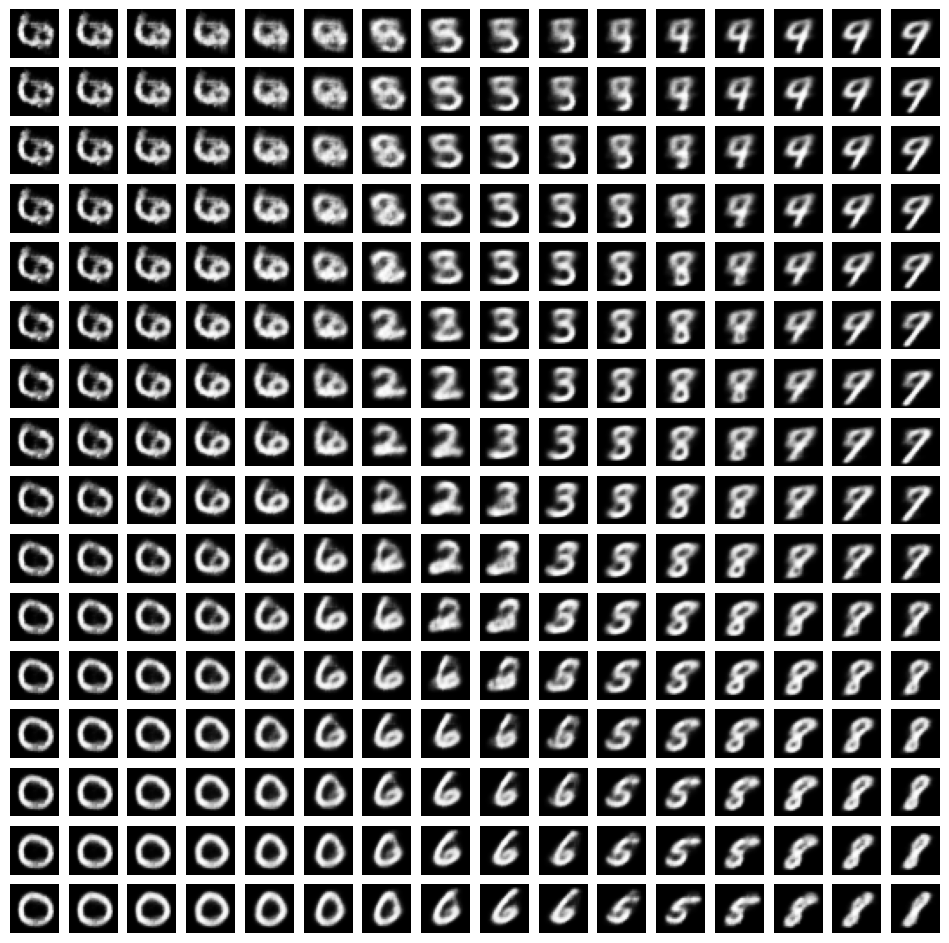

In [50]:
plt.figure(figsize=(12, 12))
k = 0
for i in grid_x:
    for j in grid_y:
        ax = plt.subplot(n, n, k+1)
        
        input_1 = tf.constant([[i, j]])
        out = model.de.predict(input_1)[0][...,0]
        plt.imshow(out, cmap="Greys_r")
        plt.axis("off")
        k += 1

In [53]:
print(vae.layers[1].predict(tf.constant([[-1,1]]))[0][...,0].shape)

1/1 [==============================] - 0s 55ms/step
(28, 28)


In [55]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
#mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(x_train, -1).astype("float32") / 255

In [59]:
z,_,_=vae.layers[1].predict(x_train)
plt.figure(figsize=(12,12))
plt.scatter(z[:,0],z[:,1],c=y_train)
plt.colorbar()
plt.show()

ValueError: in user code:

    File "C:\Users\hamid\anaconda3\envs\MachineLearning\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\hamid\anaconda3\envs\MachineLearning\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\hamid\anaconda3\envs\MachineLearning\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\hamid\anaconda3\envs\MachineLearning\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\hamid\anaconda3\envs\MachineLearning\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\hamid\anaconda3\envs\MachineLearning\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "decoder" is incompatible with the layer: expected shape=(None, 2), found shape=(32, 28, 28)
